# Deep Reinforcement Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import skimage.transform
from IPython.display import Image, display

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

2024-01-02 19:45:57.824873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices("GPU") 
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


2024-01-02 19:45:58.992012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-02 19:45:58.992146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-02 19:45:58.996362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-02 19:45:58.996513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-02 19:45:58.996615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [3]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
from ple.games.flappybird import FlappyBird
from ple import PLE

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

test_game = FlappyBird()
test_env = PLE(test_game, fps=30, display_screen=False)
test_env.reset_game()

couldn't import doomish
Couldn't import doom


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [4]:
path = './movie_f' 
if not os.path.exists(path):
    os.makedirs(path)

In [5]:
hparas = {
    'image_size': 84,
    'num_stack': 4,
    'action_dim': len(env.getActionSet()),
    'hidden_size': 256,
    'lr': 0.0001,
    'gamma': 0.99,
    'lambda': 0.95,
    'clip_val': 0.2,
    'ppo_epochs': 8,
    'test_epochs': 1,
    'num_steps': 512,
    'mini_batch_size': 64,
    'target_reward': 200,
    'max_episode': 30000,
}

In [6]:
# Please do not modify this method
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    
    return clip

In [7]:
def preprocess_screen(screen):
    screen = skimage.transform.rotate(screen, -90, resize=True)
    screen = screen[:400, :]
    screen = skimage.transform.resize(screen, [hparas['image_size'], hparas['image_size'], 1])
    return screen.astype(np.float32)

def frames_to_state(input_frames):
    if(len(input_frames) == 1):
        state = np.concatenate(input_frames*4, axis=-1)
    elif(len(input_frames) == 2):
        state = np.concatenate(input_frames[0:1]*2 + input_frames[1:]*2, axis=-1)
    elif(len(input_frames) == 3):
        state = np.concatenate(input_frames + input_frames[2:], axis=-1)
    else:
        state = np.concatenate(input_frames[-4:], axis=-1)

    return state

In [8]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, hparas):
        super().__init__()

        self.feature_extractor = tf.keras.Sequential([
          # Convolutional Layers
          tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1),
          tf.keras.layers.ReLU(),
          # Embedding Layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(hparas['hidden_size']),
          tf.keras.layers.ReLU(),
        ])

        # Actor Network
        self.actor = tf.keras.layers.Dense(hparas['action_dim'], activation='softmax')
        # Critic Network
        self.critic = tf.keras.layers.Dense(1, activation = None)

    def call(self, input):
        x = self.feature_extractor(input)
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value

In [9]:
class Agent():
    def __init__(self, hparas):
        self.gamma = hparas['gamma']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparas['lr'])
        self.actor_critic = ActorCriticNetwork(hparas)
        self.clip_pram = hparas['clip_val']
    
    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = tf.convert_to_tensor(np.random.randint(0, batch_size, mini_batch_size), dtype=tf.int32)
            yield tf.gather(states, rand_ids), tf.gather(actions, rand_ids), tf.gather(log_probs, rand_ids), \
             tf.gather(returns, rand_ids), tf.gather(advantage, rand_ids)
    
    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, discount_rewards, advantages):       
        total_actor_loss = 0
        total_critic_loss = 0
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, reward, advantage in self.ppo_iter(mini_batch_size, states, actions, log_probs, discount_rewards, advantages):
                reward = tf.expand_dims(reward, axis=-1)

                with tf.GradientTape() as tape:
                    prob, value = self.actor_critic(state, training=True)
                    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
                    entropy = tf.math.reduce_mean(dist.entropy())
                    new_log_probs = dist.log_prob(action)

                    # PPO ratio
                    ratio = tf.math.exp(new_log_probs - old_log_probs)
                    surr1 = ratio * advantage
                    surr2 = tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram) * advantage

                    actor_loss = tf.math.negative(tf.math.reduce_mean(tf.math.minimum(surr1, surr2))) - 0.1 * entropy
                    critic_loss = 0.5 * tf.math.reduce_mean(kls.mean_squared_error(reward, value))

                    total_loss = actor_loss + critic_loss
            
                # single optimizer
                grads = tape.gradient(total_loss, self.actor_critic.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.actor_critic.trainable_variables))
      
                total_actor_loss += actor_loss
                total_critic_loss += critic_loss
        return total_actor_loss, total_critic_loss

In [10]:
# https://arxiv.org/pdf/1506.02438.pdf
# Equation 16
def compute_gae(rewards, masks, values, gamma, LAMBDA):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * LAMBDA * masks[i] * gae
        returns.append(gae + values[i])

    returns.reverse()
    return returns

In [11]:
def test_reward(test_env, agent):
    total_reward = 0
    # Reset the environment
    test_env.reset_game()
    input_frames = [preprocess_screen(test_env.getScreenGrayscale())]

    while not test_env.game_over():

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        action = np.argmax(prob[0].numpy())
        reward = test_env.act(test_env.getActionSet()[action])
        total_reward += reward

        input_frames.append(preprocess_screen(test_env.getScreenGrayscale()))

    return total_reward

In [12]:
agent = Agent(hparas)
max_episode = hparas['max_episode']
test_per_n_episode = 10
force_save_per_n_episode = 1000
early_stop_reward = 10

start_s = 0
best_reward = -5.0

checkpoint = tf.train.Checkpoint(
    actor_critic = agent.actor_critic,
    optimizer = agent.optimizer,
)

# Load from old checkpoint
# checkpoint.restore('ckpt_dir/ckpt-?')

In [13]:
ep_reward = []
total_avgr = []
early_stop = False
avg_rewards_list = []

env.reset_game()

for s in range(0, max_episode):
    if early_stop == True:
        break

    rewards = []
    states = []
    actions = []
    log_probs = []
    masks = []
    values = []

    display_frames = [env.getScreenRGB()]
    input_frames = [preprocess_screen(env.getScreenGrayscale())]

    for step in range(hparas['num_steps']):

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        dist = tfp.distributions.Categorical(probs=prob[0], dtype=tf.float32)
        action = dist.sample(1)
        log_prob = dist.log_prob(action)

        reward = env.act(env.getActionSet()[int(action.numpy())])

        done = env.game_over()

        states.append(state)
        actions.append(action)
        values.append(value[0])
        log_probs.append(log_prob)
        rewards.append(tf.convert_to_tensor(reward, dtype=tf.float32))
        masks.append(tf.convert_to_tensor(1-int(done), dtype=tf.float32))

        display_frames.append(env.getScreenRGB())
        input_frames.append(preprocess_screen(env.getScreenGrayscale()))

        if done:
            env.reset_game()
            input_frames = [preprocess_screen(env.getScreenGrayscale())]
  
    _, next_value = agent.actor_critic(state)
    values.append(next_value[0])

    returns = compute_gae(rewards, masks, values, hparas['gamma'], hparas['lambda'])

    returns = tf.concat(returns, axis=0)
    log_probs = tf.concat(log_probs, axis=0)
    values = tf.concat(values, axis=0)
    states = tf.concat(states, axis=0)
    actions = tf.concat(actions, axis=0)
    advantage = returns - values[:-1]

    a_loss, c_loss = agent.ppo_update(hparas['ppo_epochs'], hparas['mini_batch_size'], states, actions, log_probs, returns, advantage)
    print('[Episode %d]  Actor loss: %.5f, Critic loss: %.5f' % (s, a_loss, c_loss))

    if s % test_per_n_episode == 0:
        # test agent hparas['test_epochs'] times to get the average reward
        avg_reward = np.mean([test_reward(test_env, agent) for _ in range(hparas['test_epochs'])])
        print("Test average reward is %.1f, Current best average reward is %.1f\n" % (avg_reward, best_reward))
        avg_rewards_list.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
            checkpoint.save(file_prefix = './save/checkpoints/ckpt')

    if s % force_save_per_n_episode == 0:
        agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        checkpoint.save(file_prefix = './save/checkpoints/ckpt')
        clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie_f/{}_demo-{}.webm".format('Lab15', s), fps=60)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if best_reward >= early_stop_reward:
        early_stop = True

2024-01-02 19:46:00.509594: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2024-01-02 19:46:01.415296: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[Episode 0]  Actor loss: 88.19614, Critic loss: 61.18818
Test average reward is -4.0, Current best average reward is -5.0



INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-4.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-4.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-4.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-4.0/assets


Moviepy - Building video movie_f/Lab15_demo-0.webm.
Moviepy - Writing video movie_f/Lab15_demo-0.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1]  Actor loss: 46.12010, Critic loss: 30.36899
[Episode 2]  Actor loss: 32.91392, Critic loss: 27.32444
[Episode 3]  Actor loss: 7.16864, Critic loss: 13.08594
[Episode 4]  Actor loss: 13.29795, Critic loss: 11.03522
[Episode 5]  Actor loss: 6.63868, Critic loss: 7.42439
[Episode 6]  Actor loss: -1.56361, Critic loss: 6.49808
[Episode 7]  Actor loss: 2.96519, Critic loss: 4.52614
[Episode 8]  Actor loss: 1.00094, Critic loss: 3.96978
[Episode 9]  Actor loss: -0.13825, Critic loss: 4.25983
[Episode 10]  Actor loss: -0.94433, Critic loss: 3.36875
Test average reward is -4.0, Current best average reward is -4.0

[Episode 11]  Actor loss: 2.77843, Critic loss: 3.72446
[Episode 12]  Actor loss: -0.85686, Critic loss: 2.92982
[Episode 13]  Actor loss: -4.45681, Critic loss: 3.02134
[Episode 14]  Actor loss: -6.20755, Critic loss: 2.40394
[Episode 15]  Actor loss: -7.62259, Critic loss: 2.24885
[Episode 16]  Actor loss: -2.84895, Critic loss: 2.72140
[Episode 17]  Actor loss: -1.775

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1000_-5.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1000_-5.0/assets


Moviepy - Building video movie_f/Lab15_demo-1000.webm.
Moviepy - Writing video movie_f/Lab15_demo-1000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-1000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1001]  Actor loss: 4.71376, Critic loss: 1.51762
[Episode 1002]  Actor loss: -6.02778, Critic loss: 1.02538
[Episode 1003]  Actor loss: -7.94479, Critic loss: 1.06586
[Episode 1004]  Actor loss: -3.02864, Critic loss: 1.06016
[Episode 1005]  Actor loss: -26.76015, Critic loss: 2.20379
[Episode 1006]  Actor loss: -0.40903, Critic loss: 2.11948
[Episode 1007]  Actor loss: -3.19154, Critic loss: 2.37132
[Episode 1008]  Actor loss: -8.82481, Critic loss: 3.98787
[Episode 1009]  Actor loss: -1.42965, Critic loss: 2.64851
[Episode 1010]  Actor loss: -0.79743, Critic loss: 2.76077
Test average reward is -5.0, Current best average reward is -4.0

[Episode 1011]  Actor loss: 9.29018, Critic loss: 1.74671
[Episode 1012]  Actor loss: 3.42645, Critic loss: 1.71353
[Episode 1013]  Actor loss: -19.66079, Critic loss: 1.56790
[Episode 1014]  Actor loss: 5.12728, Critic loss: 2.49954
[Episode 1015]  Actor loss: -13.09284, Critic loss: 1.74067
[Episode 1016]  Actor loss: -3.58975, Critic loss:

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1380_-3.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1380_-3.0/assets


[Episode 1381]  Actor loss: 4.79357, Critic loss: 3.83809
[Episode 1382]  Actor loss: 1.89230, Critic loss: 3.58437
[Episode 1383]  Actor loss: -3.74112, Critic loss: 3.63403
[Episode 1384]  Actor loss: -0.88383, Critic loss: 4.29888
[Episode 1385]  Actor loss: -14.63340, Critic loss: 4.64936
[Episode 1386]  Actor loss: -10.89413, Critic loss: 1.88515
[Episode 1387]  Actor loss: -29.18855, Critic loss: 3.74030
[Episode 1388]  Actor loss: -5.02669, Critic loss: 2.34857
[Episode 1389]  Actor loss: -12.07927, Critic loss: 3.46108
[Episode 1390]  Actor loss: -14.85939, Critic loss: 5.19566
Test average reward is -4.0, Current best average reward is -3.0

[Episode 1391]  Actor loss: -9.16193, Critic loss: 2.46576
[Episode 1392]  Actor loss: -1.85840, Critic loss: 3.31391
[Episode 1393]  Actor loss: -12.61110, Critic loss: 2.63741
[Episode 1394]  Actor loss: 1.63793, Critic loss: 2.21950
[Episode 1395]  Actor loss: -16.91275, Critic loss: 3.41327
[Episode 1396]  Actor loss: 3.31341, Critic l

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1560_3.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1560_3.0/assets


[Episode 1561]  Actor loss: -12.91921, Critic loss: 4.22867
[Episode 1562]  Actor loss: -8.25966, Critic loss: 3.13723
[Episode 1563]  Actor loss: -17.04328, Critic loss: 4.35675
[Episode 1564]  Actor loss: -12.46957, Critic loss: 4.22364
[Episode 1565]  Actor loss: -8.06581, Critic loss: 5.57112
[Episode 1566]  Actor loss: -13.13443, Critic loss: 13.94028
[Episode 1567]  Actor loss: -7.37337, Critic loss: 7.75275
[Episode 1568]  Actor loss: -7.37825, Critic loss: 7.04913
[Episode 1569]  Actor loss: -12.29188, Critic loss: 4.97303
[Episode 1570]  Actor loss: -7.63539, Critic loss: 3.27424
Test average reward is -3.0, Current best average reward is 3.0

[Episode 1571]  Actor loss: 9.15872, Critic loss: 5.71192
[Episode 1572]  Actor loss: 1.18871, Critic loss: 10.68619
[Episode 1573]  Actor loss: -1.62872, Critic loss: 5.53858
[Episode 1574]  Actor loss: -16.31150, Critic loss: 6.32148
[Episode 1575]  Actor loss: 3.30609, Critic loss: 5.53800
[Episode 1576]  Actor loss: -21.14230, Critic

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1710_4.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1710_4.0/assets


[Episode 1711]  Actor loss: -7.28735, Critic loss: 3.48243
[Episode 1712]  Actor loss: -13.68183, Critic loss: 4.10052
[Episode 1713]  Actor loss: -10.39117, Critic loss: 4.32702
[Episode 1714]  Actor loss: -11.53047, Critic loss: 5.75169
[Episode 1715]  Actor loss: -11.39357, Critic loss: 5.68686
[Episode 1716]  Actor loss: -2.47601, Critic loss: 7.12172
[Episode 1717]  Actor loss: 10.94217, Critic loss: 8.32588
[Episode 1718]  Actor loss: -12.44319, Critic loss: 5.79530
[Episode 1719]  Actor loss: -5.60654, Critic loss: 6.16770
[Episode 1720]  Actor loss: 9.09935, Critic loss: 4.78341
Test average reward is -5.0, Current best average reward is 4.0

[Episode 1721]  Actor loss: -6.70214, Critic loss: 3.52462
[Episode 1722]  Actor loss: -17.74587, Critic loss: 4.81421
[Episode 1723]  Actor loss: -18.08965, Critic loss: 9.81281
[Episode 1724]  Actor loss: -14.75506, Critic loss: 5.34927
[Episode 1725]  Actor loss: -11.04379, Critic loss: 2.78976
[Episode 1726]  Actor loss: -0.43941, Crit

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2000_-1.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2000_-1.0/assets


Moviepy - Building video movie_f/Lab15_demo-2000.webm.
Moviepy - Writing video movie_f/Lab15_demo-2000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-2000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 2001]  Actor loss: 13.49038, Critic loss: 8.64298
[Episode 2002]  Actor loss: 17.17255, Critic loss: 7.58096
[Episode 2003]  Actor loss: -13.17559, Critic loss: 8.71451
[Episode 2004]  Actor loss: -10.12302, Critic loss: 6.72809
[Episode 2005]  Actor loss: -16.69426, Critic loss: 6.78780
[Episode 2006]  Actor loss: -4.38901, Critic loss: 10.08598
[Episode 2007]  Actor loss: -13.51269, Critic loss: 6.54765
[Episode 2008]  Actor loss: 0.91612, Critic loss: 8.40028
[Episode 2009]  Actor loss: -7.58370, Critic loss: 7.80967
[Episode 2010]  Actor loss: -26.78631, Critic loss: 5.51646
Test average reward is -3.0, Current best average reward is 4.0

[Episode 2011]  Actor loss: 8.70676, Critic loss: 9.35782
[Episode 2012]  Actor loss: -28.87696, Critic loss: 7.25193
[Episode 2013]  Actor loss: -8.63993, Critic loss: 4.55208
[Episode 2014]  Actor loss: -10.37626, Critic loss: 13.65957
[Episode 2015]  Actor loss: -24.48762, Critic loss: 9.97499
[Episode 2016]  Actor loss: -21.90278, Cri

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2120_13.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2120_13.0/assets


In [14]:
print(f'Best reward: {best_reward}')

Best reward: 13.0


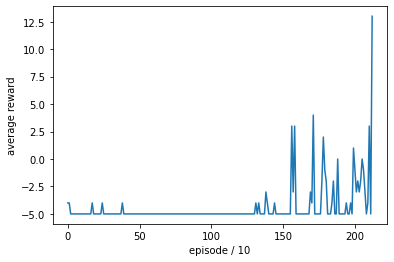

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(len(avg_rewards_list)), avg_rewards_list)
plt.xlabel('episode / 10')
plt.ylabel('average reward')
plt.show()

# Report

觀察average reward可以看出，在1500個episode後，慢慢地開始可以越過第一個棍子，並且在約2200個episode之後可以到達13也就是這次實驗中的best reward